In [122]:
from pymongo import MongoClient

In [123]:
client = MongoClient('localhost', 27017)

In [119]:
db = client['pn']

In [56]:
db = client['pn-50']

In [124]:
db = client['pn_all']

In [311]:
db = client['pn-pruned']

In [125]:
purchase_list = list(db['transactions'].find({'items.1': { '$exists': True } }, projection=['items']))

In [126]:
len(purchase_list)

936409

# Network Analysis

In [127]:
import json
class ProductNerwork:
    def __init__(self, graph):
        self.graph = graph
        self.communities = graph.community_fastgreedy(weights='weight').as_clustering()
        for index, vertex in enumerate(self.graph.vs):
            vertex.update_attributes({ 'community': self.communities.membership[index], 'id': index })

    def get_communities(self, sort=True):
        dics = []
        for subgraph in self.communities.subgraphs():
            nums = len(subgraph.vs)
            weight_sum = sum([edge['weight'] for edge in subgraph.es]) * (nums) / nums / (nums + 1)
            comm_name = [ node['name'] for node in subgraph.vs]
            dic = {
                'weight': weight_sum,
                'items': comm_name
            }
            dics.append(dic)
        if sort:
            return sorted(dics, key=lambda x : x['weight'], reverse=True)
        return dics

    def get_connectors(self):
        items = []
        for index, value in enumerate(self.graph.betweenness(weights='weight')):
            if value > 0:
                items.append({ 'name': self.graph.vs[index]['name'], 'betweeness': value })
        items.sort(key=lambda x: x['betweeness'], reverse=True)
        return items
    
    def normalizer(self, max_degree):
        max_value = max_degree
        min_value = 1
        def normalize(value):
            return (value - min_value) / max_value + 1
        return normalize
    
    def to_json(self):
        norm = self.normalizer(self.graph.maxdegree())
        nodes = []
        edges = []
        for edge in self.graph.es:
            edge_attr = {}
            edge_attr['from'], edge_attr['to'] = edge.tuple
            edge_attr['weight'] = edge['weight']
            edges.append(edge_attr)
        for node in self.graph.vs:
            node_attr = {}
            node_attr = { key: node[key] for key in node.attributes()}
            node_attr['degree'] = node.degree()
            nodes.append(node_attr)
        return json.dumps({
            'nodes': nodes,
            'edges': edges,
        }, indent=4)

In [128]:
from igraph import *
from itertools import filterfalse, combinations

class NetworkConverter:
    def __init__(self, purchase_list):
        self.purchase_list = purchase_list
    
    def convert(self, method='degree-price', support=0.001):
        support = int(len(self.purchase_list) * support)
        result = {}
        nodes = set()
        for transaction in purchase_list:
            itemsets = transaction['items']
            if len(itemsets) > 1:
                edge_list = list(self.find_edges_in_list(itemsets))
                length = len(edge_list)
                for edge_dict_tuple in edge_list:
                    edge = tuple([dic['單品名稱'] for dic in edge_dict_tuple])
                    if method == 'degree':
                        weight = 1
                        if edge in result or (edge[1], edge[0]) in result:
                            edge_in_list = edge if edge in result else (edge[1], edge[0])
                            result[edge_in_list]['count'] += 1
                            result[edge_in_list]['weight'] = weight
                        else:
                            result[edge] = {}
                            result[edge]['count'] = 1
                            result[edge]['weight'] = weight
                    else:
                        if method == 'degree-price':
                            weight = sum([dic['amount'] for dic in edge_dict_tuple]) / length
                        elif method == 'adjust-degree':
                            weight = 1 / length
                        
                        if edge in result or (edge[1], edge[0]) in result:
                            edge_in_list = edge if edge in result else (edge[1], edge[0])
                            result[edge_in_list]['count'] += 1
                            result[edge_in_list]['weight'] += weight
                        else:
                            result[edge] = {}
                            result[edge]['count'] = 1
                            result[edge]['weight'] = weight
        for key in list(result.keys()):
            if result[key]['count'] < support:
                del result[key]
        for items in result.keys():
            for item in items:
                if item not in nodes:
                    nodes.add(item)
        return self.to_graph(nodes, result)
    
    def find_edges_in_list(self, itemsets):
        """Return the combinations of the itemsets.
        """
        result = []
        return combinations(itemsets, 2)
    
    def to_graph(self, nodes, edges):
        g = igraph.Graph()
        for node in nodes:
            g.add_vertex(node)
        for edge, attrs in edges.items():
            weight = attrs['weight'] if attrs['weight'] > 0 else 1
            g.add_edge(edge[0], edge[1], weight=weight)
        return ProductNerwork(g)

In [129]:
# adjusted: add calculate weight of nodes in communities
import json
class ProductNerwork:
    def __init__(self, graph):
        self.graph = graph
        self.communities = graph.community_fastgreedy(weights='weight').as_clustering()
        for index, vertex in enumerate(self.graph.vs):
            vertex.update_attributes({ 'community': self.communities.membership[index], 'id': index })

    def get_communities(self, sort=True):
        dics = []
        for subgraph in self.communities.subgraphs():
            nums = len(subgraph.vs)
#             weight_sum = sum([edge['weight'] for edge in subgraph.es])
            weight_sum = sum([edge['weight'] for edge in subgraph.es]) * (nums) / nums / (nums + 1)
#             comm_name = [ node['name'] for node in subgraph.vs]
            ###############################
            items_weight_dict = {}
            for node in subgraph.vs:
                edges_id = subgraph.incident(node['name'], mode=OUT)
#                 node_weight_sum = 0
#                 for e in edges_id:
#                     node_weight_sum += subgraph.es[e]["weight"]
                node_weight = sum([subgraph.es[e]["weight"] for e in edges_id])
                items_weight_dict[node['name']] = node_weight
            if len(subgraph.vs) > 3:
                core = max(items_weight_dict, key=lambda x: items_weight_dict[x])
            else:
                core = ''
            ###############################
            dic = {
                'weight': weight_sum,
#                 'items': comm_name
                'items': items_weight_dict,
                'core': core
            }
            dics.append(dic)
        if sort:
            return sorted(dics, key=lambda x : x['weight'], reverse=True)
        return dics

    def get_connectors(self):
        items = []
        for index, value in enumerate(self.graph.betweenness(weights='weight')):
            if value > 0:
                items.append({ 'name': self.graph.vs[index]['name'], 'betweeness': value })
        items.sort(key=lambda x: x['betweeness'], reverse=True)
        return items
    
    def normalizer(self, max_degree):
        max_value = max_degree
        min_value = 1
        def normalize(value):
            return (value - min_value) / max_value + 1
        return normalize
    
    def to_json(self):
        norm = self.normalizer(self.graph.maxdegree())
        nodes = []
        edges = []
        for edge in self.graph.es:
            edge_attr = {}
            edge_attr['from'], edge_attr['to'] = edge.tuple
            edge_attr['weight'] = edge['weight']
            edges.append(edge_attr)
        ######################## added #########################
        core_list = []
        for subgraph in self.communities.subgraphs():
            items_weight_dict = {}
            for node in subgraph.vs:
                edges_id = subgraph.incident(node['name'], mode=OUT)
                node_weight = sum([subgraph.es[e]["weight"] for e in edges_id])
                items_weight_dict[node['name']] = node_weight
            if len(subgraph.vs) > 3:
                core_list.append(max(items_weight_dict, key=lambda x: items_weight_dict[x]))
        ########################################################
        for node in self.graph.vs:
            node_attr = {}
            node_attr = { key: node[key] for key in node.attributes()}
            node_attr['degree'] = node.degree()
            ######################## added ######################
            if node['name'] in core_list:
                node_attr['border'] = 5
#                 node_attr['core'] = True
            else:
                node_attr['border'] = 0
#                 node_attr['core'] = False
            #####################################################
            nodes.append(node_attr)
        return json.dumps({
            'nodes': nodes,
            'edges': edges,
        }, indent=4)

In [130]:
#adjusting

import igraph
import numpy as np
from itertools import filterfalse, combinations

class NetworkConverter:
    def __init__(self, purchase_list):
        self.purchase_list = purchase_list
    
    def convert(self, method = 'degree-price', support = 0.0002):
        #support = int(len(self.purchase_list) * support)
        result = {}
        nodes = set()
        for transaction in purchase_list:
            itemsets = transaction['items']
            if len(itemsets) > 1:
                edge_list = list(self.find_edges_in_list(itemsets))
                length = len(edge_list)
                for edge_dict_tuple in edge_list:
                    edge = tuple([dic['單品名稱'] for dic in edge_dict_tuple])
                    weight = 1
                    if method == 'degree-price':
                        weight = sum([dic['amount'] for dic in edge_dict_tuple]) / length
                    elif method == 'adjusted-degree':
                        weight = 1 / length
                    else:
                        weight =1
                        
                    if edge in result or (edge[1], edge[0]) in result:
                        edge_in_list = edge if edge in result else (edge[1], edge[0])
                        result[edge_in_list]['count'] += 1
                        result[edge_in_list]['weight'] += weight
                    else:
                        result[edge] = {}
                        result[edge]['count'] = 1
                        result[edge]['weight'] = weight
        
        weight_list = []
        for key in list(result.keys()):
            weight_list.append(result[key]['weight'])    
        weight_support = np.percentile(weight_list, (1-support)*100)
        print(weight_support)
        for key in list(result.keys()):
            if result[key]['weight'] < weight_support:
                del result[key]
        for items in result.keys():
            for item in items:
                if item not in nodes:
                    nodes.add(item)
        return self.to_graph(nodes, result)
    
    
    def find_edges_in_list(self, itemsets):
        """Return the combinations of the itemsets.
        """
        result = []
        return combinations(itemsets, 2)
    
    def to_graph(self, nodes, edges):
        g = igraph.Graph()
        for node in nodes:
            g.add_vertex(node)
        for edge, attrs in edges.items():
            weight = attrs['weight'] if attrs['weight'] > 0 else 1
            g.add_edge(edge[0], edge[1], weight=weight)
        return ProductNerwork(g)

In [131]:
converter = NetworkConverter(purchase_list)

# degree+price

In [132]:
product_network = converter.convert(method='degree-price', support=0.0002)

17179.71200001426


In [133]:
print('Node number: {}\nEdge number: {}'.format(len(product_network.graph.vs), len(product_network.graph.es)))

Node number: 175
Edge number: 156


# 排序Community

In [134]:
communities = product_network.get_communities()
for community in communities:
    print(community['weight'])
    print(' '.join(community['items']))
    print('==============')

81364.16268546271
紅標料理米酒 空瓶回收（銷售用）
74209.87878787877
店到店ＦＰ手續費 ＦＰ簡訊寄件 ＦＰ線上寄 ＡＰＰ寄件 ＦＰ店到店
55581.48651000759
大口ＢＢＱ牛肉起司堡飯糰 熱美式中杯 鮮奶茶 熱美式大杯 特濃黑可可 熱蜜香紅茶拿鐵 商品預售應稅 大口法香烤雞飯糰 冰美式大杯 熱拿鐵大杯 熱巧克力中杯 冰拿鐵大杯 熱重烘焙拿鐵中杯 大口奶油蕈菇起司雞排飯糰 熱拿鐵中杯
45325.66297899632
代銷即３００點ＭｙＣａｒｄ 代銷即５００點ＭｙＣａｒｄ 代銷即９０元ＭｙＣａｒｄ 代銷即１０００ＭｙＣａｒｄ 台中停車補單 代銷即３０００元ＭｙＣａｒｄ 代銷即２０００點ＭｙＣａｒｄ 代銷即５０００元ＭｙＣａｒｄ
43889.12397435891
（串）抽取式衛生紙 商品預售免稅 １０００點特價優惠Ａ１ 林鳳營全脂鮮乳９３６ｍｌ
38522.119047619046
代銷即貝殼幣３５０點 代銷即貝殼幣１４０點 代銷即貝殼幣７００點 代銷即貝殼幣１４００點
36536.763920468075
光泉全脂鮮乳 蕃薯（２０元） 經典原味熱狗 全家熱狗麵包 特濃抹茶拿鐵 茶葉蛋（銷售用） 蕃薯（１５元） 蕃薯（２５元） 統一陽光無糖高纖豆漿
35659.17460317461
ＥＺ寄件付 ｅｚ店到店手續費
35633.550264550235
戰禍邪神第１６章 戰禍邪神第１５章
35614.91005291002
戰禍邪神第１８章 戰禍邪神第１７章
35470.86406186403
戰禍邪神第１４章 戰禍邪神第１３章
34158.20634920634
戰禍邪神第１１章 戰禍邪神第１２章
31593.150561404687
麥香奶茶ＴＰ３００ （預）戽斗星球公仔磁鐵（藍色款） 雲絲頓藍７毫克香煙 大衛杜夫１０毫克香煙 尊爵Ｇ７ 長壽白軟包香菸 麥香紅茶ＴＰ３００ 金裝大衛杜夫７毫克香煙 峰硬盒香煙 安全裝置火石打火機 長壽黃硬盒香煙 雲絲頓紅１０毫克香煙 戽斗星球公仔磁鐵（藍色款） 七星天藍７毫克硬盒 伯朗咖啡 純喫茶綠茶６５０ｍｌ 藍山咖啡 天然水 純喫茶紅茶６５０ｍｌ 茶裏王日式綠茶 ＵＣＣ無糖咖啡飲料 貝納頌經典拿鐵 七星１０毫克硬盒香煙
31466.928571428576
蝦皮寄件Ｆ 雅虎拍賣寄件

In [136]:
for community in communities:
    print('weight:', community['weight'])
    print('items:', community['items'])
    print('core:', community['core'])
    print('======================================')

weight: 81364.16268546271
items: {'紅標料理米酒': 244092.48805638813, '空瓶回收（銷售用）': 244092.48805638813}
core: 
weight: 74209.87878787877
items: {'店到店ＦＰ手續費': 445259.2727272727, 'ＦＰ簡訊寄件': 25618.85714285714, 'ＦＰ線上寄': 58872.4761904762, 'ＡＰＰ寄件': 39187.04761904762, 'ＦＰ店到店': 321580.89177489176}
core: 店到店ＦＰ手續費
weight: 55581.48651000759
items: {'大口ＢＢＱ牛肉起司堡飯糰': 18367.7238095238, '熱美式中杯': 126755.828860029, '鮮奶茶': 81721.1592241093, '熱美式大杯': 153492.64972364242, '特濃黑可可': 18107.560678210666, '熱蜜香紅茶拿鐵': 17471.99177489178, '商品預售應稅': 377298.2115717615, '大口法香烤雞飯糰': 87317.8943001444, '冰美式大杯': 19175.054761904765, '熱拿鐵大杯': 352358.29376718064, '熱巧克力中杯': 41070.08802308802, '冰拿鐵大杯': 128779.61652661067, '熱重烘焙拿鐵中杯': 28806.690476190473, '大口奶油蕈菇起司雞排飯糰': 56810.23433233438, '熱拿鐵中杯': 271074.57049062074}
core: 商品預售應稅
weight: 45325.66297899632
items: {'代銷即３００點ＭｙＣａｒｄ': 53398.26839826841, '代銷即５００點ＭｙＣａｒｄ': 193475.55555555556, '代銷即９０元ＭｙＣａｒｄ': 18203.333333333332, '代銷即１０００ＭｙＣａｒｄ': 174154.45887445888, '台中停車補單': 30000.0, '代銷即３０００元ＭｙＣ

# 更新Vertex的attribute(Community)

In [15]:
data = product_network.to_json()

In [346]:
with open('D:\MIS_Project\product-netowork-demo\src\default.json', 'w', encoding='utf-8') as file:
    file.write(data)

# 原始degree

In [137]:
product_network = converter.convert(method='degree', support=0.0002)

815.9952000002377


In [138]:
print('Node number: {}\nEdge number: {}'.format(len(product_network.graph.vs), len(product_network.graph.es)))

Node number: 117
Edge number: 156


# 排序Community

In [139]:
communities = product_network.get_communities()
for community in communities:
    print(community['weight'])
    print(' '.join(community['items']))
    print('==============')

4245.789473684211
筊白筍 千層玉子燒 關東煮本舖拉麵 日式烤竹輪 日式黑輪 特級花枝丸 白玉蘿蔔 黃金魚豆腐 讚岐烏龍麵 黃金厚切魚板 旗魚黑輪 貢丸 手工高麗菜捲 關東煮本舖冬粉 蟹肉糰子 鮮香菇 海鮮魚卵棒 究極味付蛋
2234.235294117647
健保費代收 中信有線代 國泰世華卡 台中二段停 台灣自來水 欣中天然氣 遠傳電信 台新信用卡 台灣電力 花旗信用卡 國民年金代 台灣大哥大 玉山信用卡 勞保費代收 代收手續費４ 中華電信
1896.0
店到店ＦＰ手續費 ＦＰ店到店
1472.25
麥香奶茶ＴＰ３００ 光泉全脂鮮乳 鮪魚飯糰 蕃薯（２０元） 熱美式中杯 經典原味熱狗 全家熱狗麵包 特濃抹茶拿鐵 義美奶茶 麥香紅茶ＴＰ３００ 茶葉蛋（銷售用） 蕃薯（１５元） 麥香綠茶ＴＰ３００ 大口法香烤雞飯糰 蕃薯（２５元） 伯朗咖啡 藍山咖啡 天然水２．２Ｌ 七星１０毫克硬盒香煙 熱拿鐵中杯 鹼性離子水 （新）銷售用購物袋１８號袋 統一陽光無糖高纖豆漿
1351.1666666666667
代收手續費１５ 中信外１５ 雅虎拍賣繳費 玉山淘寶款 合庫代１５
1278.8
蝦皮寄件Ｆ 商店街寄件Ｆ 雅虎拍賣寄件 店到店雅虎拍賣手續費
1234.3333333333333
商店街寄件Ｗ 蝦皮寄件Ｗ 露天寄件Ｗ 雅虎線上寄件 店到店雅虎拍賣線上手續費
1178.6666666666667
台鐵取票 台鐵手續費
1163.3333333333333
紅標料理米酒 空瓶回收（銷售用）
972.25
代收手續費５ 通行繳費 ｅＴａｇ繳費
929.3333333333334
高鐵手續費 高鐵取票
791.6666666666666
瑞士爽口糖 綜合水果糖珠 代收折價卷 偉特鮮奶油糖 奶香綠茶３３０ＭＬ
669.75
（串）抽取式衛生紙 １０００點特價優惠Ａ１ 林鳳營全脂鮮乳９３６ｍｌ
641.0
寶物交易代 代收手續費２５
623.0
蝦皮取件Ｃ 商店街取件
619.75
聯合報 自由時報 蘋果日報
593.6
熱美式大杯 商品預售應稅 熱拿鐵大杯 冰拿鐵大杯
474.3333333333333
代收手續費６ 台中裁罰單
463.0
促銷券０６ 孔雀香酥脆－海苔
459.6666666666667
湖池屋洋芋片海苔鹽口味 促銷券０３
442.33333333

In [140]:
for community in communities:
    print('weight:', community['weight'])
    print('items:', community['items'])
    print('core:', community['core'])
    print('======================================')

weight: 4245.789473684211
items: {'筊白筍': 1959, '千層玉子燒': 9125, '關東煮本舖拉麵': 19253, '日式烤竹輪': 1785, '日式黑輪': 14778, '特級花枝丸': 13174, '白玉蘿蔔': 18113, '黃金魚豆腐': 15541, '讚岐烏龍麵': 8357, '黃金厚切魚板': 6494, '旗魚黑輪': 4828, '貢丸': 10308, '手工高麗菜捲': 9577, '關東煮本舖冬粉': 856, '蟹肉糰子': 6286, '鮮香菇': 819, '海鮮魚卵棒': 18021, '究極味付蛋': 2066}
core: 關東煮本舖拉麵
weight: 2234.235294117647
items: {'健保費代收': 4614, '中信有線代': 891, '國泰世華卡': 1831, '台中二段停': 929, '台灣自來水': 9625, '欣中天然氣': 896, '遠傳電信': 1332, '台新信用卡': 5513, '台灣電力': 5758, '花旗信用卡': 951, '國民年金代': 7737, '台灣大哥大': 1729, '玉山信用卡': 2065, '勞保費代收': 823, '代收手續費４': 13994, '中華電信': 17276}
core: 中華電信
weight: 1896.0
items: {'店到店ＦＰ手續費': 5688, 'ＦＰ店到店': 5688}
core: 
weight: 1472.25
items: {'麥香奶茶ＴＰ３００': 3212, '光泉全脂鮮乳': 1207, '鮪魚飯糰': 915, '蕃薯（２０元）': 6541, '熱美式中杯': 1163, '經典原味熱狗': 5501, '全家熱狗麵包': 3789, '特濃抹茶拿鐵': 1305, '義美奶茶': 1101, '麥香紅茶ＴＰ３００': 4081, '茶葉蛋（銷售用）': 14229, '蕃薯（１５元）': 4479, '麥香綠茶ＴＰ３００': 849, '大口法香烤雞飯糰': 831, '蕃薯（２５元）': 2822, '伯朗咖啡': 1807, '藍山咖啡': 885, '天然水２．２Ｌ': 978, '七星１０毫克硬盒香煙': 829, '熱拿鐵

# 更新Vertex的attribute(Community)

In [45]:
data = product_network.to_json()

In [46]:
with open('D:\MIS_Project\product-netowork-demo\src\default_original.json', 'w', encoding='utf-8') as file:
    file.write(data)

# 調整後degree

In [141]:
product_network = converter.convert(method='adjusted-degree', support=0.0002)

244.42370587426086


In [142]:
print('Node number: {}\nEdge number: {}'.format(len(product_network.graph.vs), len(product_network.graph.es)))

Node number: 175
Edge number: 156


# 排序Community

In [143]:
communities = product_network.get_communities()
for community in communities:
    print(community['weight'])
    print(' '.join(community['items']))
    print('==============')

1205.2396284271342
店到店ＦＰ手續費 ＦＰ線上寄 ＦＰ店到店
998.1706182706212
紅標料理米酒 空瓶回收（銷售用）
974.9518653568514
健保費代收 國民年金代 勞保費代收 代收手續費４
962.2933621933615
台鐵取票 台鐵手續費
886.3048109298105
中信有線代 國泰世華卡 台中二段停 台灣自來水 台灣星電信 欣中天然氣 遠傳電信 台新信用卡 台灣電力 花旗信用卡 台灣大哥大 玉山信用卡 中華電信 聯邦信用卡
826.8563634777903
代收手續費１５ 中信外１５ 雅虎拍賣繳費 跨國購物款 玉山淘寶款 合庫代１５
755.7634920634899
高鐵手續費 高鐵取票
610.8130177012534
大口ＢＢＱ牛肉起司堡飯糰 熱美式中杯 鮮奶茶 熱美式大杯 特濃黑可可 商品預售應稅 大口法香烤雞飯糰 熱拿鐵大杯 冰拿鐵大杯 大口奶油蕈菇起司雞排飯糰 熱拿鐵中杯
579.9436507936505
蝦皮寄件Ｆ 商店街寄件Ｆ
564.1569160943944
義美古早傳統無糖豆奶 光泉全脂鮮乳 光泉紫色水果優酪乳 光泉低脂鮮乳 蕃薯（３０元） 蕃薯（２０元） 經典原味熱狗 全家熱狗麵包 特濃抹茶拿鐵 茶葉蛋（銷售用） 蕃薯（１５元） 爆濃起司熱狗 １０００點免費換Ａ 頂級鮮奶優格－莓果穀物脆片 蕃薯（２５元） 天然水２．２Ｌ 鹼性離子水 （新）銷售用購物袋１８號袋 天然水（全店兌換） 統一陽光無糖高纖豆漿
559.6001082251078
代收手續費５ 通行繳費 ｅＴａｇ繳費
458.96031746031554
雅虎拍賣寄件 店到店雅虎拍賣手續費
453.47171273171296
聯合報 自由時報 中國時報 蘋果日報
435.82041847041756
寶物交易代 虛擬繳費代１ 代收手續費２５
416.63803904428977
（串）抽取式衛生紙 １０００點特價優惠Ａ１ 林鳳營全脂鮮乳９３６ｍｌ
401.9440682628112
瑞士爽口糖 綜合水果糖珠 代收折價卷 偉特鮮奶油糖 小琉球手工麻花捲－綜合 奶香綠茶３３０ＭＬ
388.75359673006716
蝦皮取件Ｃ 商店街取件 九易購物 ＥＣ代收一 ＦＰ取件
380.2054123357744
麥香奶茶Ｔ

In [144]:
for community in communities:
    print('weight:', community['weight'])
    print('items:', community['items'])
    print('core:', community['core'])
    print('======================================')

weight: 1205.2396284271342
items: {'店到店ＦＰ手續費': 4820.958513708537, 'ＦＰ線上寄': 280.83809523809555, 'ＦＰ店到店': 4540.120418470441}
core: 
weight: 998.1706182706212
items: {'紅標料理米酒': 2994.5118548118635, '空瓶回收（銷售用）': 2994.5118548118635}
core: 
weight: 974.9518653568514
items: {'健保費代收': 2168.1841186590887, '國民年金代': 2459.574653124614, '勞保費代收': 247.0005550005537, '代收手續費４': 4874.759326784257}
core: 代收手續費４
weight: 962.2933621933615
items: {'台鐵取票': 2886.8800865800845, '台鐵手續費': 2886.8800865800845}
core: 
weight: 886.3048109298105
items: {'中信有線代': 403.30310245310216, '國泰世華卡': 841.3018759018757, '台中二段停': 697.5666222666214, '台灣自來水': 3633.4574869574762, '台灣星電信': 316.3887445887444, '欣中天然氣': 657.5012265512256, '遠傳電信': 855.8536796536807, '台新信用卡': 4023.8516872016894, '台灣電力': 2996.4548174048095, '花旗信用卡': 796.7546675546669, '台灣大哥大': 1336.9246586746629, '玉山信用卡': 1209.2967532467535, '中華電信': 7864.39723054724, '聯邦信用卡': 956.0917748917735}
core: 中華電信
weight: 826.8563634777903
items: {'代收手續費１５': 5787.994544344532, '中信外

# 更新Vertex的attribute(Community)

In [226]:
data = product_network.to_json()

In [227]:
with open('D:\MIS_Project\product-netowork-demo\src\default_mod.json', 'w', encoding='utf-8') as file:
    file.write(data)

In [29]:
with open('D:\MIS_Project\product-netowork-demo\src\default_group.json', 'w', encoding='utf-8') as file:
    file.write(data)

# 利用Betweeness找出可能是connector的節點

In [39]:
connectors = product_network.get_connectors()

In [40]:
for connector in connectors:
    print('{:<5}: {:<5}'.format(connector['betweeness'], connector['name']))

127.0: 茶葉蛋（銷售用）
87.0 : （新）銷售用購物袋１８號袋
43.0 : 中華電信 
32.0 : 鮪魚飯糰 
27.0 : 台新信用卡
23.0 : 國民年金代
21.0 : 國泰世華卡
20.0 : 白玉蘿蔔 
17.0 : 經典原味熱狗
17.0 : 代收手續費４
17.0 : 光泉米漿 
13.0 : 台灣自來水
9.0  : 特級花枝丸
6.0  : 代收手續費１５
4.0  : 蟹肉糰子 
4.0  : 千層玉子燒
3.0  : 黃金厚切魚板
3.0  : 促銷券０６
3.0  : 代收折價卷
2.0  : 黃金魚豆腐
1.0  : 代收手續費５
1.0  : 蘋果日報 


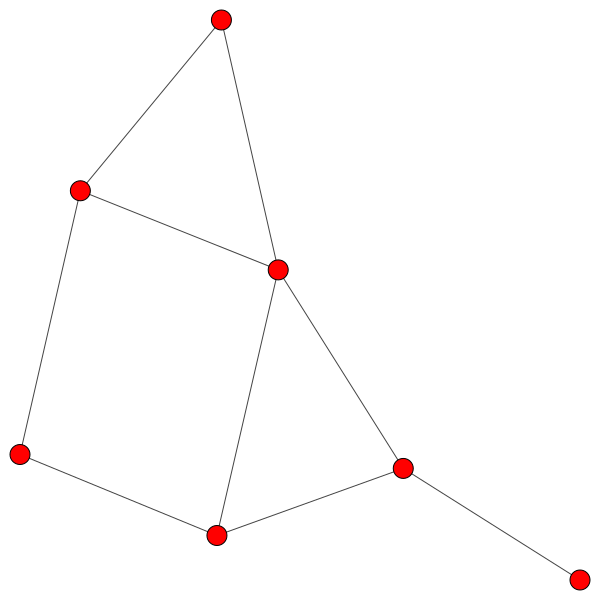

In [39]:
from igraph import *
g = Graph([(0,1), (0,2), (2,3), (3,4), (4,2), (2,5), (5,0), (6,3), (5,6)])
g.es["weight"] = [0,1,2,3,4,5,6,7,8,9]
g.vs["name"] = ["Alice", "Bob", "Claire", "Dennis", "Esther", "Frank", "George"]
plot(g)
# #You could create Vertexes like g.add_vertex(name="Bill") 
# path=g.get_shortest_paths("Alice",to="Frank",mode=OUT,output='vpath')
# for n in path[0]:
#     print("{}".format(g.vs[n]['name']))

In [40]:
g.incident('Alice', mode=OUT)

[0, 1, 6]

In [41]:
g.es[5]["weight"]

5

In [25]:
path = product_network.get_shortest_paths("鮪魚飯糰", to = "肉鬆飯糰")

AttributeError: 'ProductNerwork' object has no attribute 'get_shortest_paths'

In [74]:
max(0,9)

9

In [30]:
r = list(range(1,100))
summary(r)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [67]:
stats = {'a':1, 'b': 2, 'c': 3}
max(stats, key=lambda k: stats[k])

'c'